In [27]:
from __future__ import print_function
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import geopandas as gpd
from shapely.geometry import Point
#import pylab as pl
#%pylab inline
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Identify the problem
### Can water leak complaints be explained by building age (from PLUTO)?
First I downloaded two datasets and list the general information.The 311 data downloaded from the website has been filtered to examine water leak complaints in Manhattan in 2016.

In [28]:
# read 311 data
df_311 = pd.read_csv("311_Service_Requests_2016.csv")

In [29]:
df_311.rename(columns = { u'Incident Zip' : 'ZipCode'}, inplace=True)
df_311.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,ZipCode,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,32314281,01/02/2016 04:39:15 PM,01/14/2016 09:23:52 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,DAMP SPOT,RESIDENTIAL BUILDING,10029,238 EAST 111 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.794354,-73.941410,"(40.794354159862365, -73.94140960170793)"
1,32314296,01/02/2016 03:05:42 AM,01/06/2016 08:29:20 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10027,409 WEST 127 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.812878,-73.953553,"(40.812878357593846, -73.9535532023634)"
2,32314310,01/01/2016 10:53:27 PM,04/18/2016 09:02:45 AM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10012,107 MAC DOUGAL STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.729714,-74.000743,"(40.7297138891165, -74.00074326038714)"
3,32314311,01/02/2016 12:31:35 PM,01/10/2016 01:01:36 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10011,226 WEST 20 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
4,32316690,01/01/2016 07:41:00 PM,01/06/2016 06:56:57 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10034,541 WEST 204 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.863682,-73.920962,"(40.86368168466244, -73.92096167930647)"


In [30]:
df_311.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'ZipCode', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',
    

In [31]:
# drop columns I am not using
df_311.drop(['Unique Key',  'Closed Date', 'Agency Name',
       'Location Type',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry Direction',
       'Ferry Terminal Name'], axis=1, inplace=True)

In [32]:
# read PLUTO data in Manhattan 
df_PLUTO = pd.read_csv("MN.csv")

In [33]:
df_PLUTO.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2
3,MN,1,301,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,199 999,10101.0,NaN,0.0,NaN,4,16V2
4,MN,1,401,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,1 99 999,10101.0,NaN,0.0,NaN,4,16V2


In [34]:
df_PLUTO.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'

## 2. Descriptive statistics
### Generate descriptives for your variables of interest.
First clean two datasets.

In [35]:
df_311 = df_311.dropna(axis=0)
df_311['ZipCode'] = df_311['ZipCode'].astype(int)
df_311.reset_index(inplace=True, drop=True) #reseting index 

In [36]:
# calculate complaint numbers group by zip code
df_311 = df_311.groupby('ZipCode').size().to_frame('Complaint_Num').reset_index()

In [37]:
df_311.head()

,ZipCode,Complaint_Num
0,10001,31
1,10002,171
2,10003,87
3,10004,1
4,10006,6


In [38]:
# drop columns I am not using
df_PLUTO.drop([ 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistrict', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource',
       'NumFloors', 'UnitsRes', 'UnitsTotal','LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
       'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
       'Version'], axis=1, inplace=True)

In [39]:
# delete rows with 0 terms and NaN terms
df_PLUTO = df_PLUTO[(df_PLUTO != 0).all(1)]
df_PLUTO = df_PLUTO.dropna(axis=0)
df_PLUTO.reset_index(inplace=True, drop=True)
df_PLUTO['ZipCode'] = df_PLUTO['ZipCode'].astype(int)
df_PLUTO.head()

,Borough,ZipCode,NumBldgs,YearBuilt
0,MN,10004,158,1900
1,MN,10004,10,1900
2,MN,10004,7,1900
3,MN,10004,2,1900
4,MN,10004,1,1900


In [40]:
# normalize the building age by building numbers in different zip code area
df_PLUTO['Multiply'] = df_PLUTO['NumBldgs'] * df_PLUTO['YearBuilt']
df_PLUTO = df_PLUTO.groupby(['ZipCode']).sum().reset_index()
df_PLUTO['YearBuilt_norm'] = df_PLUTO['Multiply'] / df_PLUTO['NumBldgs']
df_PLUTO.rename(columns = { u'NumBldgs' : 'NumBldgs_sum',\
                            u'YearBuilt' : 'YearBuilt_sum'}, inplace=True)

In [41]:
df_PLUTO.head()

,ZipCode,NumBldgs_sum,YearBuilt_sum,Multiply,YearBuilt_norm
0,10001,1058,1781093,2039916,1928.086957
1,10002,1834,3028888,3525469,1922.284079
2,10003,2032,3520087,3891384,1915.051181
3,10004,288,198885,550914,1912.895833
4,10005,79,146960,152774,1933.848101


Generate descriptives for variables of interest. Merge two datasets.

In [42]:
mean1 = df_311.Complaint_Num.mean()
median1 = df_311.Complaint_Num.median()
std1 = df_311.Complaint_Num.std()
print("The mean,median and standard deviation of water leak complaints in in Manhattan are {}, {}, and {} separately."\
      .format(int(mean1),int(median1),int(std1)))

The mean,median and standard deviation of water leak complaints in in Manhattan are 146, 78, and 173 separately.


In [43]:
mean2 = df_PLUTO.YearBuilt_norm.mean()
median2 = df_PLUTO.YearBuilt_norm.median()
std2 = df_PLUTO.YearBuilt_norm.std()
print("The mean, median and standard deviation of construction year of buildings in Manhattan are {}, {}, and {} separately."\
      .format(int(mean2),int(median2),int(std2)))

The mean, median and standard deviation of construction year of buildings in Manhattan are 1931, 1927, and 20 separately.


In [44]:
# merge two datasets
df = pd.merge(df_311, df_PLUTO, on='ZipCode', how='inner') 

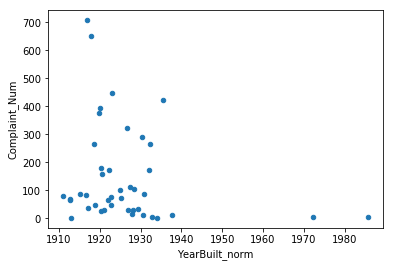

In [45]:
df.plot(kind='scatter',x='YearBuilt_norm',y='Complaint_Num')
plt.show()

We can see that the distribution of the data is very dispersed. Estimated reason for this will be included in the discussion part.

In [46]:
df.head()

,ZipCode,Complaint_Num,NumBldgs_sum,YearBuilt_sum,Multiply,YearBuilt_norm
0,10001,31,1058,1781093,2039916,1928.086957
1,10002,171,1834,3028888,3525469,1922.284079
2,10003,87,2032,3520087,3891384,1915.051181
3,10004,1,288,198885,550914,1912.895833
4,10006,6,54,102454,104369,1932.759259


## 3. Visualization
### Map the locations of 311 complaints for the specific type you have chosen.

In [47]:
df_loc = pd.read_csv('311_Service_Requests_2016.csv')
df_loc.rename(columns = { u'X Coordinate (State Plane)' : 'x_c',\
                          u'Y Coordinate (State Plane)' : 'y_c'}, inplace=True)

In [48]:
# Importing shapefile of NYC
nyshp = gpd.read_file('ZIP_CODE_040114.shp')
nyshp = nyshp[nyshp.COUNTY == 'New York']

In [49]:
leakdf.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,geometry
0,32314281,01/02/2016 04:39:15 PM,01/14/2016 09:23:52 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,DAMP SPOT,RESIDENTIAL BUILDING,10029,238 EAST 111 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.794354,-73.941410,"(40.794354159862365, -73.94140960170793)",POINT (1000473 228687)
1,32314296,01/02/2016 03:05:42 AM,01/06/2016 08:29:20 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10027,409 WEST 127 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.812878,-73.953553,"(40.812878357593846, -73.9535532023634)",POINT (997107 235434)
2,32314310,01/01/2016 10:53:27 PM,04/18/2016 09:02:45 AM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10012,107 MAC DOUGAL STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.729714,-74.000743,"(40.7297138891165, -74.00074326038714)",POINT (984044 205131)
3,32314311,01/02/2016 12:31:35 PM,01/10/2016 01:01:36 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10011,226 WEST 20 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)",POINT (984813 209834)
4,32316690,01/01/2016 07:41:00 PM,01/06/2016 06:56:57 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10034,541 WEST 204 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.863682,-73.920962,"(40.86368168466244, -73.92096167930647)",POINT (1006112 253950)


In [53]:
leakdf.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,geometry
0,32314281,01/02/2016 04:39:15 PM,01/14/2016 09:23:52 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,DAMP SPOT,RESIDENTIAL BUILDING,10029,238 EAST 111 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.794354,-73.941410,"(40.794354159862365, -73.94140960170793)",POINT (1000473 228687)
1,32314296,01/02/2016 03:05:42 AM,01/06/2016 08:29:20 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10027,409 WEST 127 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.812878,-73.953553,"(40.812878357593846, -73.9535532023634)",POINT (997107 235434)
2,32314310,01/01/2016 10:53:27 PM,04/18/2016 09:02:45 AM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10012,107 MAC DOUGAL STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.729714,-74.000743,"(40.7297138891165, -74.00074326038714)",POINT (984044 205131)
3,32314311,01/02/2016 12:31:35 PM,01/10/2016 01:01:36 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10011,226 WEST 20 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)",POINT (984813 209834)
4,32316690,01/01/2016 07:41:00 PM,01/06/2016 06:56:57 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10034,541 WEST 204 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.863682,-73.920962,"(40.86368168466244, -73.92096167930647)",POINT (1006112 253950)


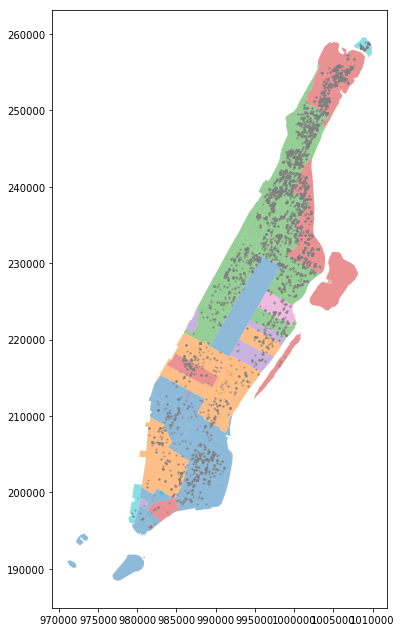

In [50]:
# Convert data to GeoDataFrame
leakdf = gpd.GeoDataFrame(df_loc)
geo = [Point(x) for x in zip(df_loc.x_c, df_loc.y_c)]
leakdf.crs = {'init': 'epsg:4326'}
leakdf.geometry = geo
fig, ax = plt.subplots(figsize=(6,11))
nyshp.plot(column = 'ZIPCODE', linewidth=0.2, alpha=0.5, ax = ax)
leakdf.plot(markersize=1.5, color = 'grey', alpha = 0.5, ax = ax)

## 4. Analysis
Run a linear regression to examine the relation between building age and water leak complaints.

In [51]:
# Performing OLS regression
lm = smf.ols(formula='df.Complaint_Num ~ df.YearBuilt_norm', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       df.Complaint_Num   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.871
Date:                Tue, 28 Nov 2017   Prob (F-statistic):              0.179
Time:                        20:41:56   Log-Likelihood:                -274.75
No. Observations:                  42   AIC:                             553.5
Df Residuals:                      40   BIC:                             557.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5294.1415   3763.605      1.407      0.167   -2312.389    1.29e+04
df.YearBuilt_norm    -2.6722      1.954     -1.368      0.179      -6.621       1.277
==============================================================================
Omnibus:                       19.086   Durbin-Watson:                   0.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.617
Skew:                           1.581   Prob(JB):                     7.44e-06
Kurtosis:                       4.871   Cond. No.                     2.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

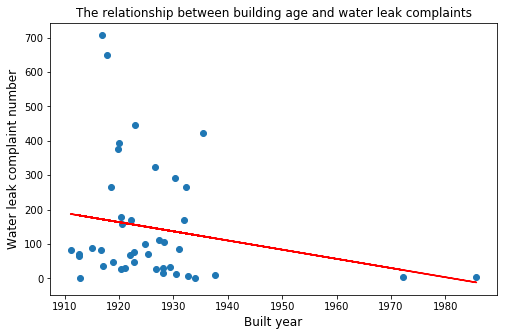

In [52]:
# Visualize the data set
plt.figure(figsize=(8,5))
plt.plot(df['YearBuilt_norm'], df['Complaint_Num'], 'o')
plt.title('The relationship between building age and water leak complaints', fontsize = 12)
plt.xlabel('Built year', fontsize = 12)
plt.ylabel('Water leak complaint number', fontsize = 12)
plt.plot(df['YearBuilt_norm'], lm.predict(), '-r')
plt.show()

## 5. Discussion
### Describe how an agency might use your findings to improve service delivery or performance. What agency(ies) would be involved? What are the limitations of your approach? What could you do to improve it?

The analysis about water leak and building age provide an insight of the housing infrastructures in New York City. It is important to the issue of affordable housing in NYC. By improving the investments on housing infrastructures and services can help to maintain a livable neighborhood. Agencies would be involved including, the New York City Department of Housing Preservation and Development (HPD), the New York State Department of Housing and Community Renewal (HCR), the New York City Housing Authority (NYCHA), and the New York City Department of Finance (DOF), etc.

From the linear regression we found that R-squared is small. This is because some of the limitations of my approach. Here I normalized the building age based on zip code, which is a quite large area. Therefore, the datasets are not big enough, and the building age data cannot precisely describe the condition a smaller area, like streets or blocks. The analysis will be improved if I use a smaller geographic unit and exclude outliers from the datasets.